# Primer ejemplo de minería de procesos

En este cuaderno, vamos a:
- Cargar con pandas un archivo de eventos
- Preparar el archivo para su procesamiento por pm4py
- Cargar el archivo en pm4py
- Vamos a hacer discovering de procesos
- Vamos a identificar los potenciales cuellos de botella o áreas de mejora.

A por ello!

In [134]:
# Importaciones que necesitamos:
import pandas as pd
import numpy as np   # Librería de operaciones matemáticas avanzadas

from pm4py.objects.conversion.log import converter

from pm4py.algo.discovery.inductive import algorithm as inductive_miner

from pm4py.objects.conversion.process_tree.variants import to_bpmn as conversor_a_bpmn
from pm4py.objects.conversion.process_tree import converter as conversor_a_petri

from pm4py.visualization.process_tree import visualizer as visualizador_de_process_trees
from pm4py.visualization.petri_net import visualizer as visualizador_redes_de_petri
from pm4py.visualization.bpmn import visualizer as visualizador_de_bpmn

from pm4py.objects.bpmn.exporter import exporter as exportador_a_bpmn

from pm4py.statistics.attributes.log import get as get_attribute_values
from pm4py.statistics.start_activities.log import get as sa_get
from pm4py.statistics.end_activities.log import get as ea_get
from pm4py.statistics.traces.generic.log import case_statistics


Lo primero que haremos será cargar con pandas el archivo de eventos.

In [100]:
datos = pd.read_csv('datos.csv', parse_dates=['timestamp'])
datos

,case_id,activity,timestamp,resource
0,1001,Pedido recibido,2025-06-01 09:00:00,Ana
1,1001,Validación,2025-06-01 10:00:00,Pedro
2,1001,Aprobación,2025-06-01 11:30:00,Juan
3,1002,Pedido recibido,2025-06-01 09:15:00,Ana
4,1002,Rechazo,2025-06-01 09:45:00,Marta


In [101]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   case_id    5 non-null      int64         
 1   activity   5 non-null      object        
 2   timestamp  5 non-null      datetime64[ns]
 3   resource   5 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 288.0+ bytes


In [102]:
datos.describe()

,case_id,timestamp
count,5.000000,5
mean,1001.400000,2025-06-01 09:54:00
min,1001.000000,2025-06-01 09:00:00
25%,1001.000000,2025-06-01 09:15:00
50%,1001.000000,2025-06-01 09:45:00
75%,1002.000000,2025-06-01 10:00:00
max,1002.000000,2025-06-01 11:30:00
std,0.547723,NaN


Cambiamos los nombres de las columnas a los que necesita pm4py. Además aprovechamos para ordenar las columnas de forma que queden como las necesita pm4py.

In [103]:
# Renombra las columnas para que pm4py las entienda
datos_preparados = datos.rename(columns={
    'case_id': 'case:concept:name',
    'activity': 'concept:name',
    'timestamp': 'time:timestamp'
})  
# Ordenar por caso y por fecha
datos_renombrados = datos_preparados.sort_values(by=['case:concept:name', 'time:timestamp'])  # Ordena los datos por case_id y timestamp

datos_preparados 

,case:concept:name,concept:name,time:timestamp,resource
0,1001,Pedido recibido,2025-06-01 09:00:00,Ana
1,1001,Validación,2025-06-01 10:00:00,Pedro
2,1001,Aprobación,2025-06-01 11:30:00,Juan
3,1002,Pedido recibido,2025-06-01 09:15:00,Ana
4,1002,Rechazo,2025-06-01 09:45:00,Marta


Le pido a la librería que cargue el DataFrame y lo transforme en un objeto de tipo Event Log.

Un event log es un objeto propio de la librería pm4py que contiene los datos del DataFrame en un formato adecuado para el análisis de procesos.

In [104]:
log = converter.apply(datos_preparados, variant = converter.Variants.TO_EVENT_LOG)  # Convierte los datos a un log de eventos de pm4py
log

[{'attributes': {'concept:name': 1001}, 'events': [{'concept:name': 'Pedido recibido', 'time:timestamp': Timestamp('2025-06-01 09:00:00'), 'resource': 'Ana'}, '..', {'concept:name': 'Aprobación', 'time:timestamp': Timestamp('2025-06-01 11:30:00'), 'resource': 'Juan'}]}, '....', {'attributes': {'concept:name': 1002}, 'events': [{'concept:name': 'Pedido recibido', 'time:timestamp': Timestamp('2025-06-01 09:15:00'), 'resource': 'Ana'}, '..', {'concept:name': 'Rechazo', 'time:timestamp': Timestamp('2025-06-01 09:45:00'), 'resource': 'Marta'}]}]

Lo que vemos ahí es un formato raro (de listas y diccionarios) en el que pm4py prepara los datos para posteriormente poder analizarlos.B

Básicamente, los agrupa por CASO.

Ese formato interno nos da igual verlo por pantalla... solo es algo que hay que hacer.

Una vez hecho esto, lo que vamos a hacer es generar un modelo, a partir de los datos que hemos cargado, para ver cómo es el proceso.

La forma más básica de modelo que tiene pm4py es lo que se llama un PROCESS TREE.

Eso es algo muy formal... y que cuando lo miro, flipo!... pero es la descripción matemática formal del modelo de proceso, al que se ajustan TODAS las entradas del log de eventos.

In [105]:
# Estamos usando un algoritmo de mineria de procesos, llamado Inductive Miner, para descubrir el modelo de proceso a partir del log de eventos.
# Hay muchos más algoritmos. Ya os pasaré una lista.
process_tree = inductive_miner.apply(log)  # Aplica el algoritmo de descubrimiento inductivo a los datos

process_tree


->( 'Pedido recibido', X( ->( 'Validación', 'Aprobación' ), 'Rechazo' ) )

Ahí podemos llegar a ver los siguientes operadores:

-> SECUENCIA: indica que una actividad(es) sigue a otra.

X  ALTERNATIVA: indica que una actividad(es) u otra puede ocurrir.

^  AND: Tareas que se ejecutan en paralelo.

⟳ ITERACIÓN: indica que una actividad(es) puede repetirse.


    SECUENCIA
    - Pedido recibido
    - ALTERNATIVA (XOR)
        - SECUENCIA
            - Validación
            - Aprobación
        - Rechazo

Esta representación es muy buena para el posterior análsis de los datos. Cuando digo muy buena, me refiero a que COMPUTACIONALMENTE ES MUY FÁCIL RECORRER ESE ÁRBOL e ir PROBANDO los datos que tenemos en el fichero de los... a ver si encajan o no con  ese árbol. ESO ES ALGO QUE HACE INTERNAMENTE LA LIBRERÍA PM4PY.

Lo que hacemos posteriormente es transformar ese process_tree en algo que nosotros podamos ver y entender mejor: un diagrama de RED DE PETRI o un diagrama BPMN.

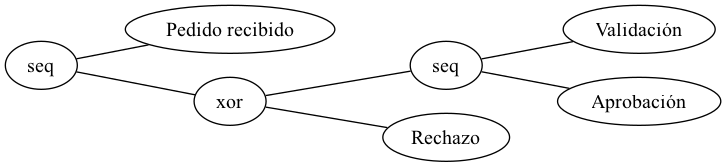

In [115]:
grafico_process_tree = visualizador_de_process_trees.apply(process_tree, parameters={"format": "png"})
visualizador_de_process_trees.save(grafico_process_tree,"process_tree.png")
visualizador_de_process_trees.view(grafico_process_tree)

Ese árbol de procesos está guay para PM4PY.. no para mi. Vamos a generar una red de petri, que podemos representar en algo que lleva un flujo!

In [107]:
red, origenes, finales = conversor_a_petri.apply(process_tree)  # Convierte el árbol de procesos a una red de Petri
red


places: [ p_3, p_4, sink, source ]
transitions: [ (24905d25-255e-4dca-b9a2-3f4e53f6d153, 'Aprobación'), (4894b6ca-5e69-4a02-bee3-55b66784936f, 'Rechazo'), (a19136ec-532f-4a61-a6b6-db8d4ff345bf, 'Pedido recibido'), (c22b4042-a987-40c5-a89a-01030b8e16ba, 'Validación') ]
arcs: [ (24905d25-255e-4dca-b9a2-3f4e53f6d153, 'Aprobación')->sink, (4894b6ca-5e69-4a02-bee3-55b66784936f, 'Rechazo')->sink, (a19136ec-532f-4a61-a6b6-db8d4ff345bf, 'Pedido recibido')->p_3, (c22b4042-a987-40c5-a89a-01030b8e16ba, 'Validación')->p_4, p_3->(4894b6ca-5e69-4a02-bee3-55b66784936f, 'Rechazo'), p_3->(c22b4042-a987-40c5-a89a-01030b8e16ba, 'Validación'), p_4->(24905d25-255e-4dca-b9a2-3f4e53f6d153, 'Aprobación'), source->(a19136ec-532f-4a61-a6b6-db8d4ff345bf, 'Pedido recibido') ]

In [108]:
origenes

['source:1']

In [109]:
finales

['sink:1']

Ahora tenemos una red de petri. Lo que vemos en pantalla es la representación INTERNA que se hace de esa red de petri... pero para verla, nos interesa más que se nos dibuje como un grafo:

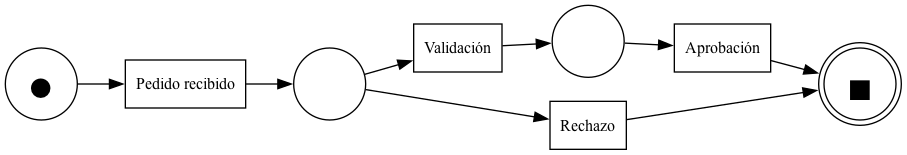

In [110]:

grafico_red_petri = visualizador_redes_de_petri.apply(red, origenes, finales, parameters={"format": "png"})  # Visualiza la red de Petri resultante del descubrimiento

visualizador_redes_de_petri.save(grafico_red_petri, "proceso.png")  # Guarda la visualización en un fichero PNG
visualizador_redes_de_petri.view(grafico_red_petri)

Igual que hemos generado un modelo PETRI del proceso, podemos generar un modelo BPMN del proceso.
Vamos a generar un modelo BPMN del proceso. 
Ese modelo posteriormente lo podemos:
- Representar gráficamente en algo más fácil de entender para los humanos.
- Exportarlo a un fichero XML que se puede importar en herramientas de modelado de procesos industriales.

In [111]:
modelo_bpmn = conversor_a_bpmn.apply(process_tree)  # Convierte el árbol de procesos a una red de Petri
modelo_bpmn

Ahora que ya tengo el modelo podemos guardarlo como xml:

In [112]:
exportador_a_bpmn.apply(modelo_bpmn, "proceso.bpmn")  # Exporta el modelo BPMN a un fichero XML

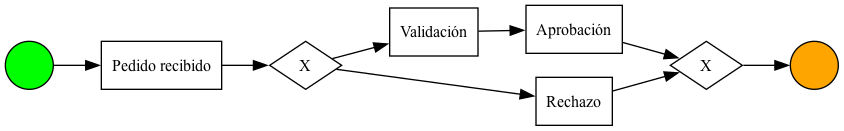

In [113]:

grafico_bpmn = visualizador_de_bpmn.apply(modelo_bpmn, parameters={"format": "png"})  # Visualiza la red de Petri resultante del descubrimiento

visualizador_de_bpmn.save(grafico_bpmn, "proceso-bpmn.png")  # Guarda la visualización en un fichero PNG
visualizador_de_bpmn.view(grafico_bpmn) # Lo muestra aqui en pantalla

La realidad es que antes de generar estos modelos, deberíamos haber hecho algún análisis descriptivo básico de los datos que tenemos en el log de evento. Eso nos permite ir entendiendo un poco mejor los datos... y empezar a detectar algunas anomalías que pudiéramos tener.

In [119]:
# Estadísticas básicas del log
print("=== ESTADÍSTICAS BÁSICAS DEL LOG ===")
print(f"Número total de casos: {len(log)}")
print(f"Número total de eventos: {sum(len(trace) for trace in log)}")


=== ESTADÍSTICAS BÁSICAS DEL LOG ===
Número total de casos: 2
Número total de eventos: 5


In [120]:

# Análisis de los casos... y su número de actividades asociadas
print("=== ANÁLISIS DEL NÚMERO DE ACTIVIDADES POR CASO ===")
longitudes_trazas = [len(trace) for trace in log] # Es una lista con las longitudes de las trazas.
# En nuestro caso tenemos [3, 2]
# [PedidoRecibido-> Validación -> Aprobación , PedidoRecibido -> Rechazo]
print(f"Longitud media de traza: {np.mean(longitudes_trazas):.2f}")
print(f"Longitud mínima de traza: {min(longitudes_trazas)}")
print(f"Longitud máxima de traza: {max(longitudes_trazas)}")
print(f"Desviación estándar longitud: {np.std(longitudes_trazas):.2f}")

=== ANÁLISIS DEL NÚMERO DE ACTIVIDADES POR CASO ===
Longitud media de traza: 2.50
Longitud mínima de traza: 2
Longitud máxima de traza: 3
Desviación estándar longitud: 0.50


In [125]:
# Estadísticas de actividades
print("\n=== ESTADÍSTICAS DE ACTIVIDADES ===")
actividades = get_attribute_values.get_attribute_values(log, "concept:name") # Tabla de frecuencias de actividades
print(f"Número de actividades únicas: {len(actividades)}")
print("\nFrecuencia de actividades:")
for actividad, frecuencia in sorted(actividades.items(), key=lambda x: x[1], reverse=True):
    print(f"  - {actividad}: {frecuencia} eventos")



=== ESTADÍSTICAS DE ACTIVIDADES ===
Número de actividades únicas: 4

Frecuencia de actividades:
  - Pedido recibido: 2 eventos
  - Validación: 1 eventos
  - Aprobación: 1 eventos
  - Rechazo: 1 eventos


In [ ]:
# Estadísticas de variantes del proceso
print("\n=== VARIANTES DEL PROCESO ===")
variantes = {}
for trace in log:
    variante = tuple([event["concept:name"] for event in trace]) # Las secuencias de actividades que se van dando en los casos (VARIANTES)
    if variante in variantes:
        variantes[variante] += 1
    else:
        variantes[variante] = 1

print(f"Número de variantes únicas: {len(variantes)}")
print(f"Variante más común: {max(variantes, key=variantes.get)} (aparece {max(variantes.values())} veces)")

print("\nTop 5 variantes más frecuentes:")
for i, (variante, frecuencia) in enumerate(sorted(variantes.items(), key=lambda x: x[1], reverse=True)[:5]):
    print(f"  {i+1}. {' → '.join(variante)} ({frecuencia} casos)")



=== VARIANTES DEL PROCESO ===
Número de variantes únicas: 2
Variante más común: ('Pedido recibido', 'Validación', 'Aprobación') (aparece 1 veces)

Top 5 variantes más frecuentes:
  1. Pedido recibido → Validación → Aprobación (1 casos)
  2. Pedido recibido → Rechazo (1 casos)


{('Pedido recibido', 'Validación', 'Aprobación'): 1,
 ('Pedido recibido', 'Rechazo'): 1}

In [ ]:

variants = case_statistics.get_variant_statistics(log)                  # Obtener estadísticas de variantes

variants = sorted(variants, key=lambda x: x['count'], reverse=True)     # Ordenar por frecuencia
for variant in variants[:5]:                                            # Mostrar las 5 variantes más frecuentes
    print(f"Variant: {variant['variant']}, Count: {variant['count']}")


Variant: ('Pedido recibido', 'Validación', 'Aprobación'), Count: 1
Variant: ('Pedido recibido', 'Rechazo'), Count: 1


In [137]:
from pm4py.statistics.traces.generic.log import case_arrival

arrival_times = case_arrival.get_case_arrival_avg(log)  # Obtener tasa de llegada de casos
print("\n=== TASA DE LLEGADA DE CASOS ===")
print(f"Tasa de llegada de casos: {arrival_times:.2f} casos por unidad de tiempo")


=== TASA DE LLEGADA DE CASOS ===
Tasa de llegada de casos: 900.00 casos por unidad de tiempo


In [135]:
# Análisis de actividades iniciales y finales (VERSIÓN OPTIMIZADA)
print("\n=== ACTIVIDADES INICIALES Y FINALES ===")

# Obtener actividades iniciales usando funciones nativas
actividades_iniciales = sa_get.get_start_activities(log)
print("Actividades iniciales:")
for actividad, frecuencia in sorted(actividades_iniciales.items(), key=lambda x: x[1], reverse=True):
    porcentaje = (frecuencia / len(log)) * 100
    print(f"  - {actividad}: {frecuencia} casos ({porcentaje:.1f}%)")

# Obtener actividades finales usando funciones nativas
actividades_finales = ea_get.get_end_activities(log)
print("\nActividades finales:")
for actividad, frecuencia in sorted(actividades_finales.items(), key=lambda x: x[1], reverse=True):
    porcentaje = (frecuencia / len(log)) * 100
    print(f"  - {actividad}: {frecuencia} casos ({porcentaje:.1f}%)")

# Estadísticas adicionales
print(f"\nNúmero de actividades iniciales únicas: {len(actividades_iniciales)}")
print(f"Número de actividades finales únicas: {len(actividades_finales)}")

# Actividades que son tanto iniciales como finales
actividades_ambas = set(actividades_iniciales.keys()) & set(actividades_finales.keys())
if actividades_ambas:
    print(f"\nActividades que pueden ser tanto iniciales como finales: {list(actividades_ambas)}")
else:
    print("\nNo hay actividades que sean tanto iniciales como finales")


=== ACTIVIDADES INICIALES Y FINALES ===
Actividades iniciales:
  - Pedido recibido: 2 casos (100.0%)

Actividades finales:
  - Aprobación: 1 casos (50.0%)
  - Rechazo: 1 casos (50.0%)

Número de actividades iniciales únicas: 1
Número de actividades finales únicas: 2

No hay actividades que sean tanto iniciales como finales


In [ ]:
# Análisis temporal
print("\n=== ANÁLISIS TEMPORAL A NIVEL DE PROCESO ===")

# Duración de casos (si hay timestamps)
if len(log) > 0 and len(log[0]) > 0 and "time:timestamp" in log[0][0]:
    duraciones = []
    for trace in log:
        if len(trace) > 1:
            inicio = trace[0]["time:timestamp"]
            fin = trace[-1]["time:timestamp"]
            duracion = (fin - inicio).total_seconds() / 3600  # en horas
            duraciones.append(duracion)
    
    if duraciones:
        print(f"Duración mínima: {min(duraciones):.2f} horas")
        print(f"Duración máxima: {max(duraciones):.2f} horas")
        print(f"Duración media del proceso: {np.mean(duraciones):.2f} horas")
        print(f"Desviación estándar de duración: {np.std(duraciones):.2f} horas")
        print(f"Mediana de duración: {np.median(duraciones):.2f} horas")
        percentil25 = np.percentile(duraciones, 25)
        percentil75 = np.percentile(duraciones, 75)
        rango_semi_intercuartilico = (percentil75 - percentil25) / 2
        print(f"Rango semi-intercuartílico de duración: {rango_semi_intercuartilico:.2f} horas")

        percentil95 = np.percentile(duraciones, 95)
        print(f"95% de los casos tienen una duración menor a: {percentil95:.2f} horas")

else:
    print("No hay información temporal disponible en el log")


=== ANÁLISIS TEMPORAL ===
Duración mínima: 0.50 horas
Duración máxima: 2.50 horas
Duración media del proceso: 1.50 horas
Desviación estándar de duración: 1.00 horas
Mediana de duración: 1.50 horas
Rango semi-intercuartílico de duración: 0.50 horas
95% de los casos tienen una duración menor a: 2.40 horas
